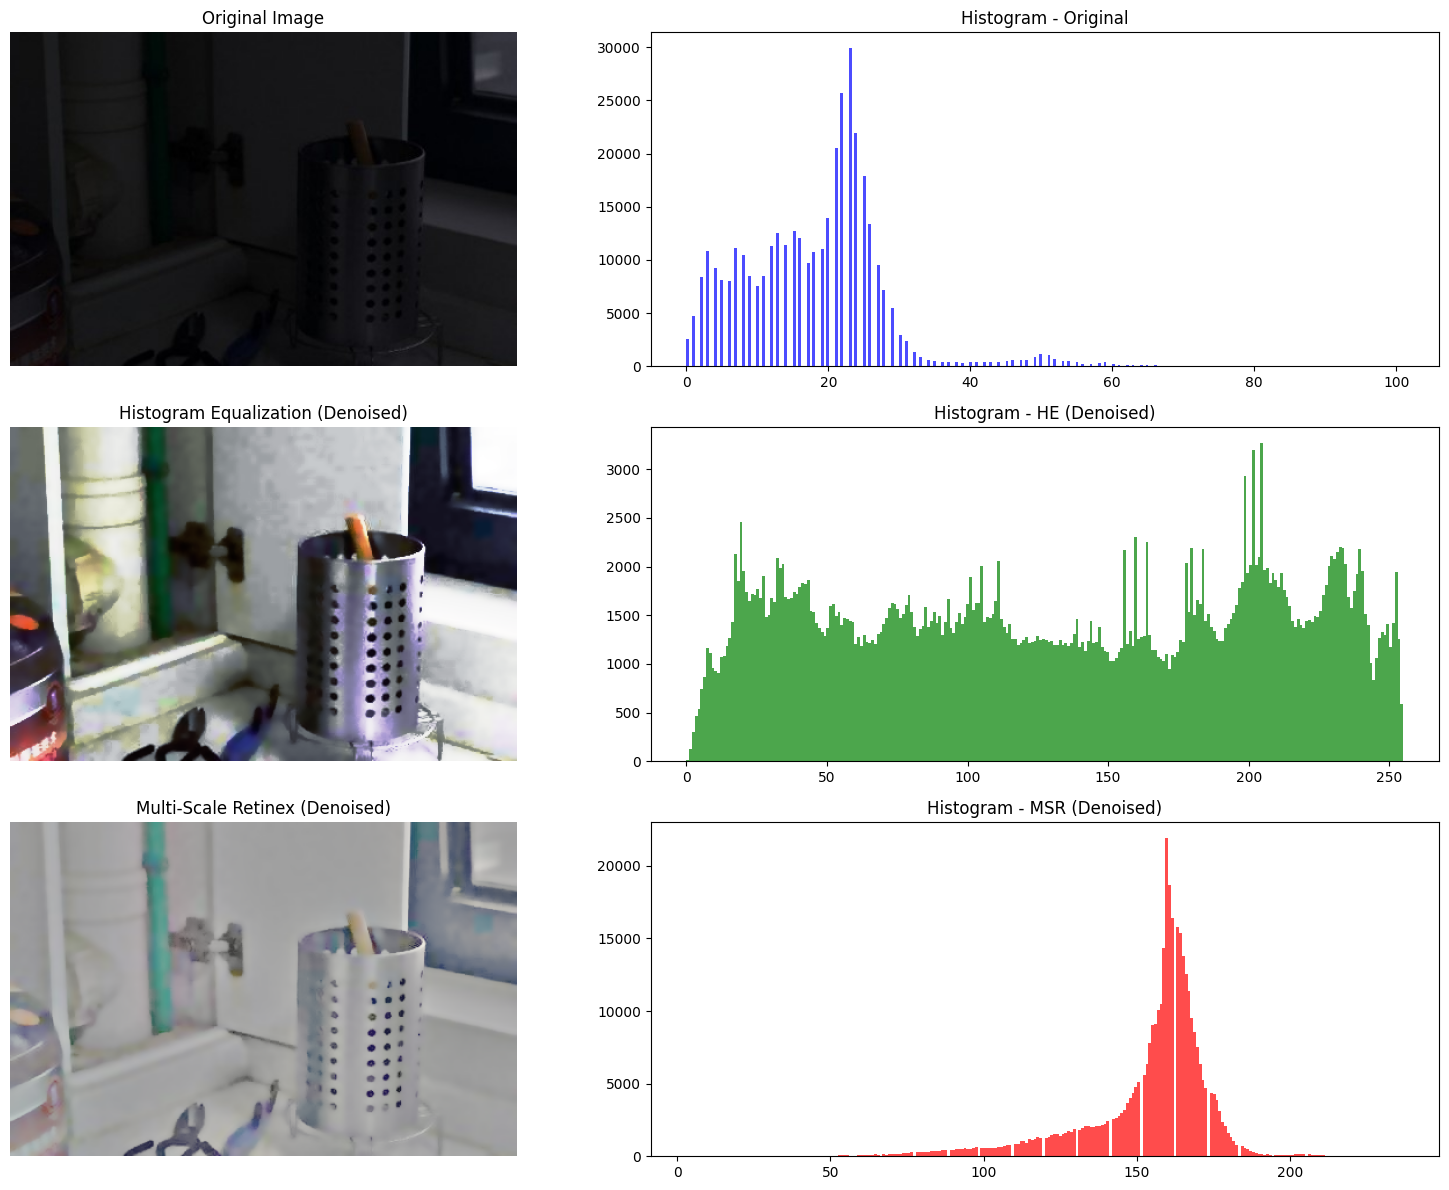

Metric     HE         MSR       
------------------------------
SNR        -0.30      0.42      
PSNR       27.73      28.45     
MSE        109.77     92.92     
RMSE       10.48      9.64      


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper Functions
def calculate_metrics(original, processed):
    mse = np.mean((original - processed) ** 2)
    rmse = np.sqrt(mse)
    psnr = 10 * np.log10(255**2 / mse)
    signal_power = np.mean(original ** 2)
    noise_power = mse
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('-inf')
    return snr, psnr, mse, rmse

# Denoising Function
def apply_denoising(image):
    denoised = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised

# Load Image
image_path = "gbr .jpg"  # Path to the uploaded file
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Apply Histogram Equalization (Per Channel for Color Images)
def apply_histogram_equalization(image):
    equalized = np.zeros_like(image)
    for channel in range(image.shape[2]):  # Process each channel separately
        equalized[:, :, channel] = cv2.equalizeHist(image[:, :, channel])
    return equalized

he_result = apply_histogram_equalization(original_image)

# Apply Multi-Scale Retinex (MSR)
def apply_msr(image, scales=[25, 100, 175]):
    image = image.astype(np.float32) + 1.0  # Avoid log(0)
    msr_result = np.zeros_like(image)

    for scale in scales:
        # Ensure the scale is odd
        if scale % 2 == 0:
            scale += 1
        for channel in range(image.shape[2]):  # Process each channel separately
            blurred = cv2.GaussianBlur(image[:, :, channel], (scale, scale), 0)
            msr_result[:, :, channel] += np.log1p(image[:, :, channel]) - np.log1p(blurred)

    # Average the result over the number of scales
    msr_result = msr_result / len(scales)
    msr_result = cv2.normalize(msr_result, None, 0, 255, cv2.NORM_MINMAX)
    return msr_result.astype(np.uint8)

msr_result = apply_msr(original_image)

# Apply Denoising
he_denoised = apply_denoising(he_result)
msr_denoised = apply_denoising(msr_result)

# Calculate Metrics
snr_he, psnr_he, mse_he, rmse_he = calculate_metrics(original_image, he_denoised)
snr_msr, psnr_msr, mse_msr, rmse_msr = calculate_metrics(original_image, msr_denoised)

# Plot Results
plt.figure(figsize=(16, 12))

# Original Image
plt.subplot(3, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Histogram of Original Image
plt.subplot(3, 2, 2)
plt.title("Histogram - Original")
plt.hist(original_image.ravel(), bins=256, color='blue', alpha=0.7)

# HE Result
plt.subplot(3, 2, 3)
plt.title("Histogram Equalization (Denoised)")
plt.imshow(cv2.cvtColor(he_denoised, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Histogram of HE Result
plt.subplot(3, 2, 4)
plt.title("Histogram - HE (Denoised)")
plt.hist(he_denoised.ravel(), bins=256, color='green', alpha=0.7)

# MSR Result
plt.subplot(3, 2, 5)
plt.title("Multi-Scale Retinex (Denoised)")
plt.imshow(cv2.cvtColor(msr_denoised, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Histogram of MSR Result
plt.subplot(3, 2, 6)
plt.title("Histogram - MSR (Denoised)")
plt.hist(msr_denoised.ravel(), bins=256, color='red', alpha=0.7)

plt.tight_layout()
plt.show()

# Display Metrics in a Table
print(f"{'Metric':<10} {'HE':<10} {'MSR':<10}")
print(f"{'-'*30}")
print(f"{'SNR':<10} {snr_he:<10.2f} {snr_msr:<10.2f}")
print(f"{'PSNR':<10} {psnr_he:<10.2f} {psnr_msr:<10.2f}")
print(f"{'MSE':<10} {mse_he:<10.2f} {mse_msr:<10.2f}")
print(f"{'RMSE':<10} {rmse_he:<10.2f} {rmse_msr:<10.2f}")
